In [1]:
import numpy as np
import zlib
import glob
import h5py
import pickle
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from generator_class_multi_1226 import DataGenerator
from tqdm import tqdm
import concurrent.futures
import matplotlib.pyplot as plt

2024-01-22 22:39:06.524972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
plt.style.use('/home/sophiaf/mystyle.mplstyle')

In [3]:
class DataGenerator2(keras.utils.Sequence):
    '''
    going to assume you've already preselected the energy ROI. 
    can run get_data if you haven't yet and save to pickle file the results. 
    '''
    
    def __init__(self, df, batch_size, dim, n_channels):
        # self.files = files
        self.df = df
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        # self.t = TicToc()

    # __normalize__ method removed
    
    def get_info(self, file):
        with open(file, 'rb') as info_file:
            info = info_file.readlines()
            truth = {}
            truth['NuPDG'] = int(info[7].strip())
            truth['NuEnergy'] = float(info[1])
            truth['LepEnergy'] = float(info[2])
            truth['Interaction'] = int(info[0].strip()) % 4
            truth['NProton'] = int(info[8].strip())
            truth['NPion'] = int(info[9].strip())
            truth['NPizero'] = int(info[10].strip())  
            truth['NNeutron'] = int(info[11].strip())
            truth['is_antineutrino'] = int(int(info[7].strip())<0)
            truth['LepAngle'] = float(info[15].strip())
            truth['image_path'] = file[:-5] + '.gz'

            # extra labels for ML classification
            pdg = np.abs(truth['NuPDG'])
            if pdg == 1: truth['flavour'] = 0 #NC
            elif pdg == 12: truth['flavour'] = 1 #CC nu_e
            elif pdg == 14: truth['flavour'] = 2 #CC nu_mu
            elif pdg == 16: truth['flavour'] = 3 #CC nu_tau (not included in our E range but still here) 
            truth['protons'] = np.clip(truth['NProton'], None, 3) # 0,1,2,or N Protons 
            truth['pions'] = np.clip(truth['NPion'], None, 3) # 0,1,2,or N Pions 
            truth['pizeros'] = np.clip(truth['NPizero'], None, 3) # 0,1,2,or N Pizeros
            truth['neutrons'] = np.clip(truth['NNeutron'], None, 3) # 0,1,2,or N Neutrons 
            
        return truth
    
    def get_dataframe(self, files):
        data_labels = {}
        for i, file in enumerate(tqdm(files)):
            truth_info = self.get_info(file)
            if i==0:
                for key in truth_info.keys():
                    data_labels[key] = [truth_info[key]]
            else: 
                for key in truth_info.keys():
                    data_labels[key].append(truth_info[key])
        df = pd.DataFrame.from_dict(data_labels)
        return df

    def save_dataframe(self, df, path_to_df):
        pd.to_pickle(df, filepath_or_buffer=path_to_df)

    def load_dataframe(self, path_to_df, idx=None):
        df = pd.read_pickle(path_to_df)
        return df 
        
    def get_pixels_map(self, file_name):
        cells = self.dim[0]
        planes = self.dim[1]
        views = self.n_channels
        # with open(file_name, 'rb') as f:
        f = open(file_name, 'rb')
        file = f.read()
        pixels_map = np.frombuffer(zlib.decompress(file), dtype=np.uint8)
        f.close()
        pixels_map = pixels_map.reshape(views, planes, cells)
        return pixels_map
    
    def get_data_and_labels(self, idxs):
        data_subset = self.df.iloc[idxs]
        # data_subset = self.df.iloc[idxs[0]:idxs[1]]
        labels = ['flavour', 'protons', 'pions', 'pizeros', 'neutrons', 'is_antineutrino']
        data_label_dict = data_subset[labels]
        data_maps = []
        
        # for file in data_subset['image_path']:
        #     data_maps.append(self.get_pixels_map(file))
        
        ## Use ThreadPoolExecutor for parallel file reading
        with concurrent.futures.ThreadPoolExecutor() as executor:
            # Map the file reading function to each file in parallel
            data_maps = list(executor.map(self.get_pixels_map, data_subset['image_path']))
        return data_maps, data_label_dict

    
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        upper_point = min((index + 1) * self.batch_size, len(self.df))
        indexes = list(range(index * self.batch_size, upper_point))
        # indexes = [index*self.batch_size, upper_point]
        # files_temp = [self.files[i] for i in indexes]

        maps_temp, labels_temp = self.get_data_and_labels(indexes)
        maps_z_view = np.asarray(maps_temp)[:, 2:]
        maps_v_view = np.asarray(maps_temp)[:, 1:2]
        maps_u_view = np.asarray(maps_temp)[:, 0:1]

        train_temp = []
        if self.n_channels == 1:
            for i in range(len(maps_z_view)):
                train_temp.append(maps_z_view[i][0])

        elif self.n_channels == 3:
            for i in range(len(maps_z_view)):
                train_temp.append(np.dstack((maps_u_view[i][0], maps_v_view[i][0], maps_z_view[i][0])))
        train_temp = np.array(train_temp).reshape([self.batch_size, self.dim[0], self.dim[1], self.n_channels])
        
        # labels_temp is a dictionary containing multiple output labels
        X, y = self.__data_generation(train_temp, labels_temp)
        return X, y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
    
    def __data_generation(self, train_temp, labels_temp):
        # Convert the labels_temp dictionary to a list of tensors
        y_list = [labels_temp[key] for key in labels_temp.keys()]
        return train_temp, y_list

## preprocessing

### Turning pixel file pointers to scratch path 

In [4]:
listname = 'urllist_0_1_2_10_11_12'
path_to_df = '/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_df.pkl'
path_to_test_df = '/home/sophiaf/pixel_maps_val/preprocessed_filelists/'+listname+'_df_testset.pkl'
df1 = pd.read_pickle(path_to_df)
df1_test = pd.read_pickle(path_to_test_df)

In [5]:
generator = DataGenerator2(df1_test,64,(200,200),3)


In [6]:
maps, labs = generator.__getitem__(0)

In [35]:
masked_maps[:,:,i]

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=999999,
  dtype=uint8)

In [58]:
cmap = plt.get_cmap('gnuplot')

# Create a copy of the colormap
new_cmap = cmap.copy()

# Set the color for 0 to white
new_cmap.set_under(color='white')


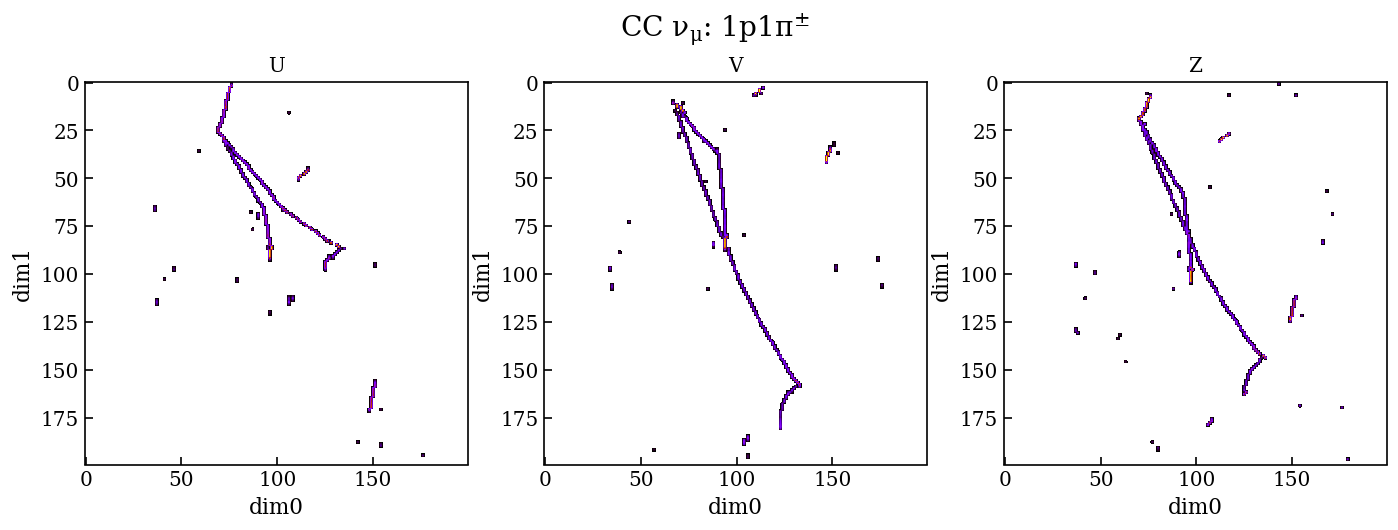

In [71]:
indx = 24
flav = labs[0][indx]
prot = labs[1][indx]
pions = labs[2][indx]
flav_labels = ['NC', 'CC $\\nu_e$', 'CC $\\nu_\\mu$']
titles = ['U', 'V', 'Z']
fig, axs = plt.subplots(1, 3, figsize=(14,4.5))

cmap = plt.get_cmap('gnuplot')
cmap.set_bad(color='white', alpha=1)

masked_maps = np.ma.masked_where(maps[indx] == 0, maps[indx])

for i, ax in enumerate(axs): 
    
    ax.imshow(maps[indx][:,:,i], cmap=new_cmap, vmin=0.00001)
    # ax.imshow(masked_maps[:, :, i], cmap=cmap, vmin=0)
    # ax.imshow()
    ax.set(xlabel='dim0', ylabel='dim1',title=titles[i])
# for ax in axs.flat:
#     ax.label_outer()
fig.suptitle('%s: %ip%i$\\pi^{\\pm}$'%(flav_labels[flav], prot, pions))
# plt.savefig('pixel_maps/pixel_maps_%s.pdf'%indx)
plt.show()